In [1]:
import librosa
import librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt
from pathlib import Path
import os
import pandas as pd
import numpy as np
from fastai.vision.all import *

In [2]:
DATA = Path('../../data')
URBAN_SOUND = DATA/'urban-sound'
URBAN_SOUND_RECORDINGS = URBAN_SOUND/'data'
#AUDIO_RECORDINGS = AUDIO_TAGGING/'audio_train'

In [3]:
dst_path = URBAN_SOUND/'train'
dst_path.mkdir(exist_ok=True)

In [4]:
URBAN_SOUND.ls()

(#5) [Path('../../data/urban-sound/train'),Path('../../data/urban-sound/data'),Path('../../data/urban-sound/FREESOUNDCREDITS.txt'),Path('../../data/urban-sound/.DS_Store'),Path('../../data/urban-sound/UrbanSound_README.txt')]

In [5]:
URBAN_SOUND_RECORDINGS.ls()

(#11) [Path('../../data/urban-sound/data/car_horn'),Path('../../data/urban-sound/data/jackhammer'),Path('../../data/urban-sound/data/siren'),Path('../../data/urban-sound/data/street_music'),Path('../../data/urban-sound/data/engine_idling'),Path('../../data/urban-sound/data/gun_shot'),Path('../../data/urban-sound/data/.DS_Store'),Path('../../data/urban-sound/data/drilling'),Path('../../data/urban-sound/data/dog_bark'),Path('../../data/urban-sound/data/children_playing')...]

In [7]:
from pydub import AudioSegment

In [35]:
children_playing = URBAN_SOUND_RECORDINGS/'street_music'
children_playing.ls()
sound = AudioSegment.from_mp3(children_playing/'7390.mp3')
sound.duration_seconds
s = sound[:10000]
s.export(children_playing/'test.mp3', format='mp3')

<_io.BufferedRandom name='../../data/urban-sound/data/street_music/test.mp3'>

In [41]:
for subdir, dirs, files in os.walk(URBAN_SOUND_RECORDINGS):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file
        source_path = Path(subdir)
        #print(filepath)
        #print(file)

        if filepath.endswith('.mp3'):
            sound = AudioSegment.from_mp3(filepath)
            sound.export(filepath, 'wav')

In [42]:
count = 0
for subdir, dirs, files in os.walk(URBAN_SOUND_RECORDINGS):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file
        source_path = Path(subdir)
        #print(filepath)
        #print(file)

        if not filepath.endswith(('.csv', '.json','.DS_Store','.aif','.flac')):
            sound = AudioSegment.from_mp3(filepath)
            file_format = file.split(".")[-1]
            if sound.duration_seconds > 20:
                print(file_format)
                first_twenty = sound[:20000]
                first_twenty.export(filepath, format=file_format)
                count += 1
                if count % 10 == 0:
                    print(count, end='\r')
print(count)

CouldntDecodeError: Decoding failed. ffmpeg returned error code: 69

Output from ffmpeg/avlib:

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzmq --enable-libzvbi --enable-lv2 --enable-omx --enable-openal --enable-opencl --enable-opengl --enable-sdl2 --enable-libdc1394 --enable-libdrm --enable-libiec61883 --enable-nvenc --enable-chromaprint --enable-frei0r --enable-libx264 --enable-shared
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
[mp3float @ 0x5629019fa3c0] Header missing
    Last message repeated 61 times
[mp3 @ 0x5629019f0700] Estimating duration from bitrate, this may be inaccurate
Input #0, mp3, from '../../data/urban-sound/data/car_horn/178402.mp3':
  Duration: 00:05:51.29, start: 0.000000, bitrate: 64 kb/s
    Stream #0:0: Audio: mp3, 44100 Hz, stereo, fltp, 64 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (mp3 (mp3float) -> pcm_s16le (native))
Press [q] to stop, [?] for help
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
Output #0, wav, to 'pipe:':
  Metadata:
    ISFT            : Lavf58.29.100
    Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, stereo, s16, 1411 kb/s
    Metadata:
      encoder         : Lavc58.54.100 pcm_s16le
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
[mp3float @ 0x5629019fb780] Header missing
Error while decoding stream #0:0: Invalid data found when processing input
size=       3kB time=00:00:03.82 bitrate=   6.6kbits/s speed= 184x    
video:0kB audio:3kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.539062%
Conversion failed!


In [20]:
def log_mel_spec_tfm(fname, label, src_path , dst_path):
    data, sample_rate = librosa.load(src_path/fname)
    
    n_fft = 1024
    hop_length = 512
    n_mels = 80
    fmin = 20
    fmax = sample_rate / 2 
    
    mel_spec_power = librosa.feature.melspectrogram(data, sr=sample_rate, n_fft=n_fft, 
                                                    hop_length=hop_length, 
                                                    n_mels=n_mels, power=2.0, 
                                                    fmin=fmin, fmax=fmax)
    
    #mel_spec_power = librosa.feature.melspectrogram(x, sr=sample_rate)
    
    mel_spec_db = librosa.power_to_db(mel_spec_power, ref=np.max)
        
    dst_path = dst_path / label
    dst_path.mkdir(exist_ok=True)
    
    dst_fname = dst_path / (fname[:-4] + '.png')
    #print(dst_fname)
    plt.imsave(dst_fname, mel_spec_db)

In [33]:
import warnings
warnings.filterwarnings('ignore')

In [36]:
count = 0
for subdir, dirs, files in os.walk(URBAN_SOUND_RECORDINGS):
    for file in files:
        #print os.path.join(subdir, file)
        filepath = subdir + os.sep + file
        source_path = Path(subdir)
        #print(filepath)
        #print(file)

        if filepath.endswith(".mp3"):
            count += 1
            if count % 10 == 0:
                print(count, end='\r')
            label = subdir.split("/")[-1]
            #print(label)
            log_mel_spec_tfm(file, label, source_path, dst_path)

KeyboardInterrupt: 

In [24]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [25]:
dls = dblock.dataloaders(dst_path)

TypeError: 'NoneType' object is not iterable

In [18]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

In [19]:
learn.load("sound_model_V1")

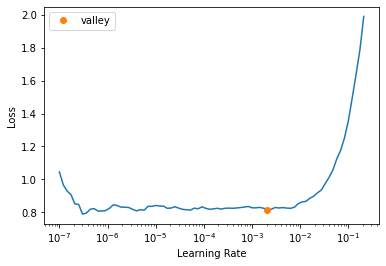

In [20]:
lr = learn.lr_find()

In [21]:
lrate = lr.valley

In [22]:
learn.fine_tune(8, lrate)

epoch,train_loss,valid_loss,accuracy,time
0,0.932528,1.130688,0.678986,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.911019,1.084895,0.708553,00:10
1,0.954422,1.207166,0.675818,00:10
2,1.005210,1.130533,0.690074,00:10
3,0.865008,1.061983,0.717529,00:10
4,0.722203,1.035566,0.727561,00:10
5,0.591072,0.965613,0.747624,00:10
6,0.496883,0.941033,0.751848,00:10
7,0.445700,0.936397,0.758184,00:10
